In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from data_loader import load_innovix_floresland, load_innovix_elbonie, load_bristor_zegoland
from tqdm import tqdm

DATA_ROOT = "./data"

In [2]:
def plot_gp(target=None, pred=None, std=None, samples=None,
        target_samples=None, figsize=None):
    plt.figure(figsize=figsize)
    if target is not None:
        plt.plot(target.index, target, c='black', label='target')
    if pred is not None:
        plt.scatter(pred.index, pred, c='tab:blue',
                label='predictions')
    if std is not None:
        plt.fill_between(pred.index, pred-1.96*std, pred+1.96*std,
                alpha=.3, fc='tab:blue', ec='None',
                label='95% C.I.')
    # Add scatter plots
    if samples is not None:
        try:
            x = samples.index
            y = samples.values
        except AttributeError:
            x = samples[0]
            y = samples[1]
        plt.scatter(x, y, color='tab:orange',
              label='samples', marker='x')
    if target_samples is not None:
        try:
            x = target_samples.index
            y = target_samples.values
        except AttributeError:
            x = target_samples[0]
            y = target_samples[1]
        plt.scatter(x, y,
                color='black', label='target', s=5)
    plt.legend()
    plt.grid(':')
    plt.tight_layout()

In [3]:
df = load_innovix_floresland(DATA_ROOT)
# df = load_innovix_elbonie(DATA_ROOT)
# df = load_bristor_zegoland(DATA_ROOT)

In [4]:
# # df_truth = pd.read_excel(os.path.join(DATA_ROOT, "INNOVIX_Floresland.xlsx"), sheet_name="Forecast volumes")
# df_truth = pd.read_excel(os.path.join(DATA_ROOT, "BRISTOR_Zegoland.xlsx"), sheet_name="Forecast volumes")
# display(df_truth["Forecast Algorithm"].unique())

# algo = "optimized arima"

# def get_df_truth(df_tr, algo, period="Monthly"):
#     df_tr = df_tr[ df_tr["Forecast Algorithm"] == algo ]
#     df_tr = df_tr[ df_tr["Data period"] == period ]
#     return df_tr

In [5]:
df

,Date,ex_factory_volumes,INNOVIX_months_of_treatment,YREX_months_of_treatment,INNOVIX_face-to-face-call_ind1,INNOVIX_face-to-face-call_ind2,INNOVIX_face-to-face-call_ind3,INNOVIX_face-to-face-call_ind5,INNOVIX_face-to-face-call_ind6,INNOVIX_face-to-face-call_ind7,...,YREX_indication_split_ind6,YREX_indication_split_ind7,YREX_indication_split_ind9,YREX_indication_split_ind10,YREX_indication_split_ind12,YREX_indication_split_ind14,YREX_indication_split_ind15,YREX_indication_split_ind19,YREX_indication_split_ind20,YREX_indication_split_ind23
0,0,3503180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2611020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2952120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2995280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2929660,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,3967620,3.707417e+06,6.252535e+06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025981,0.041698,0.006165,0.002442,0.052569,0.017831,0.0,0.571180,0.006816,0.045567
78,78,4932260,4.643238e+06,7.755752e+06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025765,0.019925,0.004417,0.004532,0.057534,0.013297,0.0,0.536082,0.013918,0.049469
79,79,4063420,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,80,4464140,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern


kernel = ConstantKernel(1, (1e-2, 1e2)) * WhiteKernel(0.1, (1e-2, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-2, 1e2))
# kernel += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 1, (1e-1, 1e1), (1e-1, 1e1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * DotProduct(1, (1e-2, 1e2))

In [7]:
import warnings
from tqdm import tqdm



# dff = df.dropna()
dff = df.set_index(["Date"], drop=False)

X = dff.drop(columns=["ex_factory_volumes"])
y = dff["ex_factory_volumes"]

X = X.fillna(X.mean())
# X = pd.DataFrame(X["Date"])

# th = 10
# X = X[-th:]
# y = y[-th:]

X = (X-X.mean())/(X.std() + 1e-9)

y_mean = y.mean()
y_std = y.std()
y = (y - y.mean()) / (y.std())



with warnings.catch_warnings(action="ignore"):

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
    # gp.fit(X, y)
    stds = []

    # Test scenario
    # new_sample = {
    #     col: np.random.normal(X[col].mean(), X[col].std(), (1,))[0]
    #     for col in X.columns
    # }
    # new_sample["INNOVIX_months_of_treatment"] *= (1 - 0.1)
    # new_sample["Date"] = 81 + 12

    # sampled_in = pd.DataFrame.from_dict([new_sample])

    # pred, std = gp.predict(sampled_in, return_std=True)
    # pred = pred[0]

    # stds.append(std)

    start_time = int(X.iloc[-1]["Date"]) + 1


    
    # X = pd.concat([ X, pd.DataFrame.from_dict([new_sample]) ])
    # y = pd.concat([ y, pd.Series([pred]) ])




    for _ in tqdm(range(20)):
        # if start_time == 81 + 12:
        #     start_time += 1
        #     continue
            
        gp.fit(X, y)

        new_sample = {
            col: np.random.normal(X[col].mean(), X[col].std(), (1,))[0]
            for col in X.columns
        }
        new_sample["Date"] = start_time

        sampled_in = pd.DataFrame.from_dict([new_sample])

        pred, std = gp.predict(sampled_in, return_std=True)
        pred = pred[0]

        stds.append(std)

        X = pd.concat([ X, pd.DataFrame.from_dict([new_sample]) ])
        y = pd.concat([ y, pd.Series([pred]) ])

        start_time += 1


        # print((pd.DataFrame.from_dict([new_sample]).columns))
        # print((dff.columns))

        # dff.loc[len(dff)] = pd.DataFrame.from_dict([new_sample])


        # dff.append(pd.DataFrame.from_dict([new_sample]))


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


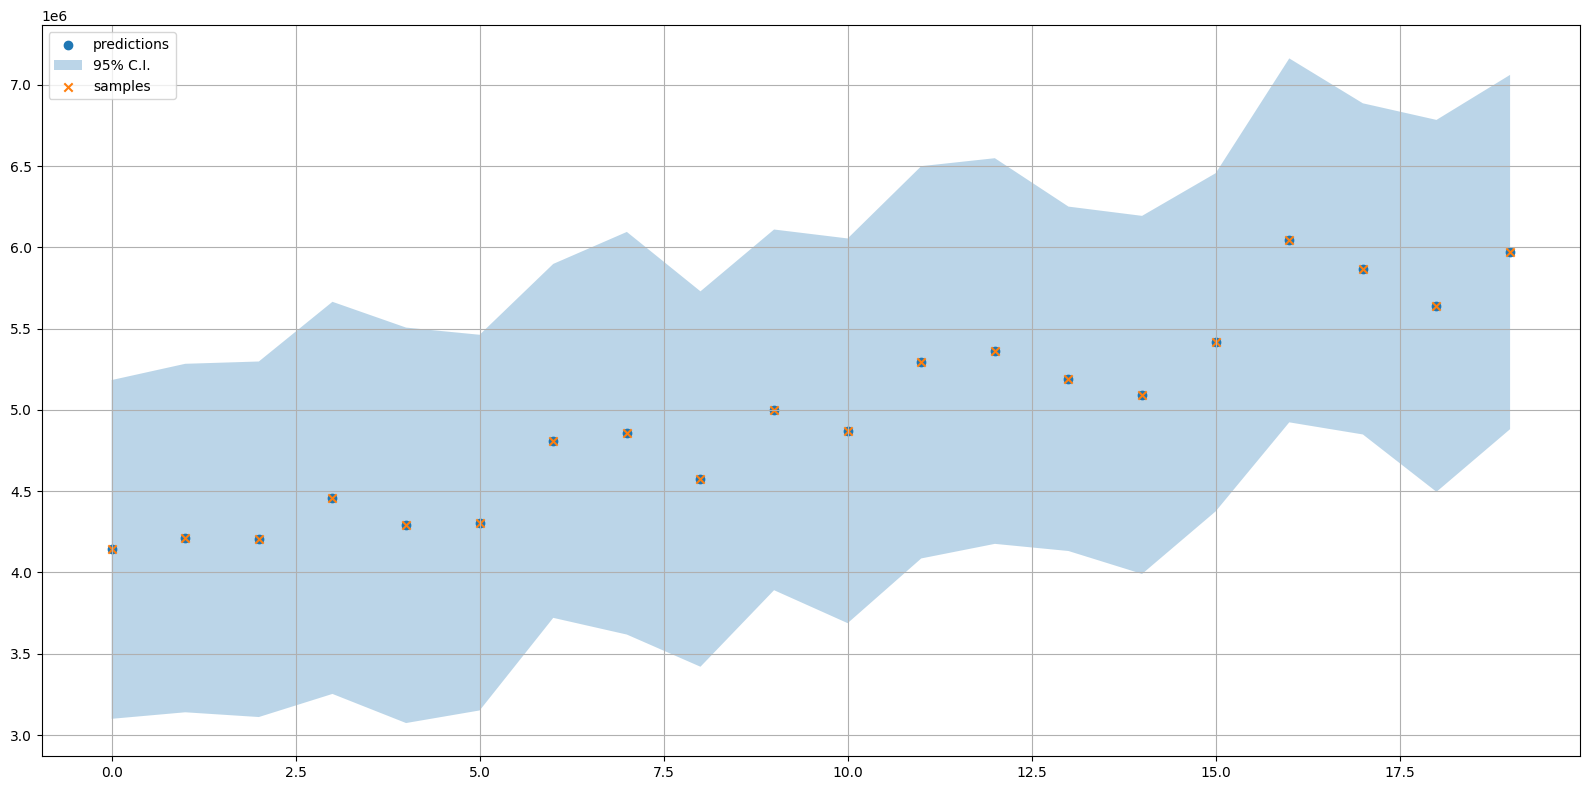

In [8]:
y_denorm = (y * y_std) + y_mean

plot_gp(
    pred = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    samples = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    std = np.array([x[0] for x in stds]) * y_std,
    figsize = (16, 8)
)

# for algo in df_truth["Forecast Algorithm"].unique():
#     df_tr = get_df_truth(df_truth, algo)
#     plt.plot(range(len(df_tr["Value"])), df_tr["Value"], label=algo)

plt.legend()
plt.show()